# lgb_7
- ただのrandom splitだとあまりよくなさそう
  - CVとLBが共によくなるようなCVを探す
  - valid 2017/1~2017/9がの方がまだ良さそう
- 日毎なので普通に10Fold validationして平均が高い方に最適化する方が良さそう
- 不要な特徴量は落とす (lgb3とは少し落とす量を減らした)
- ハイパラ調整
- 最後全データで学習
- leaderboard 532.0383805542 valid 464.6245165835615

In [1]:
import optuna
import warnings
import numpy as np
import pandas as pd
import lightgbm as lgb
from datetime import timedelta, datetime
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

pd.set_option('display.max_columns', 500)
warnings.simplefilter("ignore")

### load dataset

In [2]:
DATA_DIR = '../../dataset/input/'
train_raw = pd.read_csv(DATA_DIR + 'train.csv')
test_raw = pd.read_csv(DATA_DIR + 'test.csv')

In [3]:
train_raw.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,traffic_volume
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439
1,None,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502
2,None,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933
3,None,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576
4,None,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372


In [4]:
test_raw.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp
0,New Years Day,249.36,0.0,0.0,1,Clear,sky is clear,2018-01-01 00:00:00
1,None,249.08,0.0,0.0,1,Clear,sky is clear,2018-01-01 01:00:00
2,None,248.86,0.0,0.0,1,Clear,sky is clear,2018-01-01 02:00:00
3,None,248.72,0.0,0.0,1,Clear,sky is clear,2018-01-01 03:00:00
4,None,248.43,0.0,0.0,1,Clear,sky is clear,2018-01-01 04:00:00


In [5]:
print("shape of train df : ", train_raw.shape)
print("shape of test df : ", test_raw.shape)

shape of train df :  (37696, 9)
shape of test df :  (7949, 8)


### preprocess

In [6]:
# remove irregular data
train_raw = train_raw[train_raw['temperature'] != 0]
train_raw = train_raw[train_raw['rain_in_hour']  != 9831.30]

In [7]:
train_raw.shape

(37685, 9)

In [8]:
# feature enginnering from timestamp
def preprocessor_for_date(df):
    # basic
    df['date'] = pd.to_datetime(df['timestamp'])
    df['Year'] = df['date'].apply(lambda x: x.year)
    df['Month'] = df['date'].apply(lambda x: x.month)
    df['Day'] = df['date'].apply(lambda x: x.day)
    df['Hour'] = df['date'].apply(lambda x: x.hour)
    df['DayOfWeek'] = df['date'].apply(lambda x: x.dayofweek)
    df['DayOfYear'] = df['date'].apply(lambda x: x.dayofyear)
    df['WeekOfYear'] = df['date'].apply(lambda x: x.weekofyear)
    df['WeekOfMonth'] = df['date'].apply(lambda x: x.day // 7 + 1)
    df['Quarter'] = df['date'].apply(lambda x: x.quarter)
    # 追加する特徴量
    df['Weekend'] = np.where(df['DayOfWeek'].isin([5,6]), 1, 0)
    df['Midnight'] = np.where(df['Hour'].isin([0, 1, 2, 3, 4, 5]), 1, 0)
    df['Morning'] = np.where(df['Hour'].isin([6, 7, 8, 9, 10, 11]), 1, 0)
    df['Afternoon'] = np.where(df['Hour'].isin([12, 13, 14, 15, 16, 17]), 1, 0)
    df['Evening'] = np.where(df['Hour'].isin([18, 19, 20, 21, 22, 23]), 1, 0)
    df['StartOfMonth'] = np.where(df['Day'] <= 10, 1, 0)
    df['EndOfMonth'] = np.where(df['Day'] > 20, 1, 0)
    df['Spring'] = np.where(df['Month'].isin([4, 5]), 1, 0)
    df['Summer'] = np.where(df['Month'].isin([6, 7, 8]), 1, 0)
    df['Autumn'] = np.where(df['Month'].isin([9, 10]), 1, 0)
    df['Winter'] = np.where(df['Month'].isin([1, 2, 3, 11, 12]), 1, 0)
    return df

train_raw = preprocessor_for_date(train_raw)
test_raw = preprocessor_for_date(test_raw)

In [9]:
# fill correct value for holidays column
def preprocessor_for_holidays(df):
    df['date'] = pd.to_datetime(df['timestamp'])
    holidays_col = df[df['holiday'] != 'None']
    for holiday, date in zip(holidays_col['holiday'], holidays_col['date']):
        df['holiday'].mask((df['date'] > date) & (df['date'] < date +  timedelta(days=1)), holiday, inplace=True)
    return df

train_raw = preprocessor_for_holidays(train_raw)
test_raw = preprocessor_for_holidays(test_raw)

In [10]:
# for category value
def preprocessor_for_category_values(df):
    df['holiday'] = df['holiday'].astype('category')
    df['weather'] = df['weather'].astype('category')
    df['weather_detail'] = df['weather_detail'].astype('category')
    return df

train_raw = preprocessor_for_category_values(train_raw)
test_raw = preprocessor_for_category_values(test_raw)

In [11]:
train_raw.head()

,holiday,temperature,rain_in_hour,snow_in_hour,clouds_cover,weather,weather_detail,timestamp,traffic_volume,date,Year,Month,Day,Hour,DayOfWeek,DayOfYear,WeekOfYear,WeekOfMonth,Quarter,Weekend,Midnight,Morning,Afternoon,Evening,StartOfMonth,EndOfMonth,Spring,Summer,Autumn,Winter
0,New Years Day,263.49,0.0,0.0,58,Clouds,broken clouds,2013-01-01 00:00:00,1439,2013-01-01 00:00:00,2013,1,1,0,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1
1,New Years Day,263.78,0.0,0.0,40,Clouds,scattered clouds,2013-01-01 01:00:00,1502,2013-01-01 01:00:00,2013,1,1,1,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1
2,New Years Day,264.16,0.0,0.0,75,Snow,heavy snow,2013-01-01 02:00:00,933,2013-01-01 02:00:00,2013,1,1,2,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1
3,New Years Day,263.95,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 03:00:00,576,2013-01-01 03:00:00,2013,1,1,3,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1
4,New Years Day,263.65,0.0,0.0,90,Clouds,overcast clouds,2013-01-01 04:00:00,372,2013-01-01 04:00:00,2013,1,1,4,1,1,1,1,1,0,1,0,0,0,1,0,0,0,0,1


### train

In [12]:
# valid : 2016/01/01 ~ 2016/09/30
valid_df = train_raw[(train_raw['date'] >= "2016-01-01") & (train_raw['date'] < "2016-10-01")]
train_df = train_raw[(train_raw['date'] < "2016-01-01") | (train_raw['date'] >= "2016-10-01")]

In [13]:
# prepare dataset
all_columns = list(train_raw.columns)
ignore_columns = ['timestamp', 'date']
# importance 2桁以下の特徴量を削る
drop_columns = ['snow_in_hour', 'Year', 'StartOfMonth', 'Quarter', 'EndOfMonth']
target_columns = ['traffic_volume']
train_columns = [val for val in all_columns if val not in (ignore_columns + target_columns + drop_columns)]
X_train = train_df[train_columns]
y_train = train_df[target_columns]
X_valid = valid_df[train_columns]
y_valid = valid_df[target_columns]
test_feature = test_raw[train_columns]

In [14]:
print("Equal train feature dim to test feature dim : ", X_train.shape[1] == test_feature.shape[1])

Equal train feature dim to test feature dim :  True


In [15]:
# LGBMの学習 (optunaで最適化)

def objective(trial):
    categorical_features = ['holiday', 'weather', 'weather_detail']
    lgb_train = lgb.Dataset(X_train, np.log(y_train + 1), categorical_feature=categorical_features)
    lgb_eval = lgb.Dataset(X_valid, np.log(y_valid + 1), categorical_feature=categorical_features)

    params = {
        'objective': 'regression',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        "seed": 1234,
        "learning_rate": trial.suggest_uniform('learning_rate', 0, 1.0),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }

    gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, num_boost_round=2000,
                    early_stopping_rounds=50, verbose_eval=False)
    y_valid_log_pred = gbm.predict(X_valid)
    y_valid_pred = np.exp(y_valid_log_pred) - 1
    error = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
    return error


study = optuna.create_study()
optuna.logging.disable_default_handler()
study.optimize(objective, n_trials=50)
print('Number of finished trials: {}'.format(len(study.trials)))
print('Best trial:')
trial = study.best_trial
print('Value: {}'.format(trial.value))

Number of finished trials: 100
Best trial:
Value: 459.9439415020765


In [16]:
# best paramで再学習
categorical_features = ['holiday', 'weather', 'weather_detail']
lgb_train = lgb.Dataset(X_train, np.log(y_train + 1), categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, np.log(y_valid + 1), categorical_feature=categorical_features)
base_params = {
    'objective': 'regression',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    "seed": 1234,
}
params = {**base_params, **study.best_params}
gbm = lgb.train(params, lgb_train, valid_sets=lgb_eval, num_boost_round=2000, 
                early_stopping_rounds=50, verbose_eval=False)

In [17]:
# validation
y_valid_log_pred = gbm.predict(X_valid)
y_valid_pred = np.exp(y_valid_log_pred) - 1
error = np.sqrt(mean_squared_error(y_valid, y_valid_pred))
print('Valid score : ', error)

Valid score :  459.9439415020765


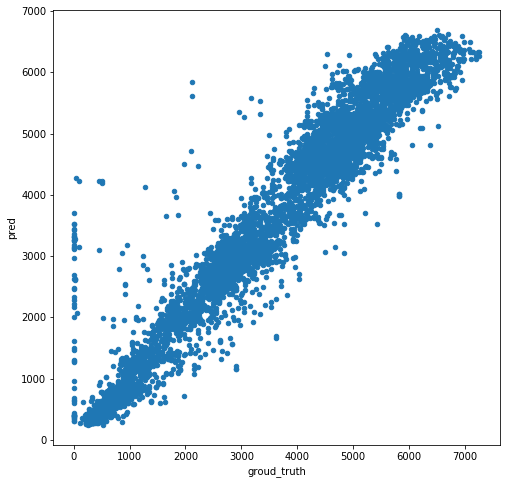

In [18]:
result = pd.DataFrame()
result['pred'] = y_valid_pred
result['groud_truth'] = y_valid.values
result.plot.scatter(x='groud_truth', y='pred', figsize=(8, 8))

#### feature importance

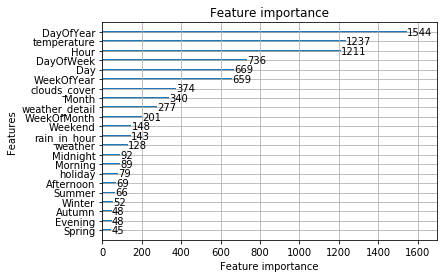

In [19]:
lgb.plot_importance(gbm)

In [20]:
feature_imp = pd.DataFrame(sorted(zip(gbm.feature_importance(), train_columns), reverse=True), columns=['Value','Feature'])
feature_imp

,Value,Feature
0,1544,DayOfYear
1,1237,temperature
2,1211,Hour
3,736,DayOfWeek
4,669,Day
5,659,WeekOfYear
6,374,clouds_cover
7,340,Month
8,277,weather_detail
9,201,WeekOfMonth


### submission

In [21]:
# 全データで学習
X_all_train = train_raw[train_columns]
y_all_train = train_raw[target_columns]

categorical_features = ['holiday', 'weather', 'weather_detail']
lgb_train = lgb.Dataset(X_all_train, np.log(y_all_train + 1), 
                        categorical_feature=categorical_features)

base_params = {
    'objective': 'regression',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    "seed": 1234,
}

params = {**base_params, **study.best_params}
gbm = lgb.train(params, lgb_train, num_boost_round=gbm.best_iteration)

In [22]:
y_test_log_pred = gbm.predict(test_feature)
y_test_pred = np.exp(y_test_log_pred) - 1

#save predictions in rows
save_path = './submission/v7lgb{}.txt'.format(9263289631)
np.savetxt(save_path, y_test_pred.T)